# Fluorescence images of GFP variants
---

### Overview
This notebook visualizes fluorescence images of two GFP variants (GFP1_2 and GFP1_10) selected from a larger experimental dataset. Each variant is expressed in *E. coli* and visualized using dual-channel fluorescence microscopy with excitation at 488 nm to detect GFP fluorescence and excitation at 561 nm to detect mKate fluorescence. The resulting plots comprise panels of a figure in the pub, demonstrating the fluorescence characteristics of these variants, which are representative of the set of GFP variants examined in this study.

### Acquisition settings
We created an image acquisition workflow using Nikon Elements JOBS. The workflow allowed us to automatically acquire multichannel images in a 4×2 grid. The channels of the multichannel acquisition were as follows:

1. `"GFP mKate"`:
   - Excitation: 561 nm
   - Emission: 595 nm
   - Power: 20 mW
   - Exposure: 200 ms
2. `"GFP 488 nm"`: 
   - Excitation: 488 nm
   - Emission: 512 nm
   - Power: 60 mW
   - Exposure: 500 ms   

**Microscope settings**:
- Magnification: 40× (no zoom) // 0.95 NA air objective
- Dimensions: (2, 1152, 1152)
- Pixel size: (0.325 µm, 0.325 µm)
- Binning: 2×2

In [1]:
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import nd2
import numpy as np
import skimage as ski

apc.mpl.setup()

### Load microscopy data

The code below assumes you have the microscopy image files in the `data/` directory such that your file structure resembles:

```bash
data/
├── Point0004_ChannelGFP mKate,GFP 488 nm_Seq0004.nd2
├── Point0007_ChannelGFP mKate,GFP 488 nm_Seq0007.nd2
└── seq_and_score.csv
```

In [2]:
# Path to image data
input_directory = Path("../data")
nd2_paths = sorted(input_directory.glob("*.nd2"))

# Names of variants
gfp_variants = ["GFP1_2", "GFP1_10"]

# Map variant names to paths
nd2_path_map = {name: path for name, path in zip(gfp_variants, nd2_paths, strict=True)}
nd2_path_map

{'GFP1_2': PosixPath('../data/Point0004_ChannelGFP mKate,GFP 488 nm_Seq0004.nd2'),
 'GFP1_10': PosixPath('../data/Point0007_ChannelGFP mKate,GFP 488 nm_Seq0007.nd2')}

### Functions for generating figure panels

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure


def create_opaque_colormap(
    color: tuple | str,
    name: str = "",
) -> LinearSegmentedColormap:
    """Create a colormap from black to the given color."""
    colors = [
        (0, 0, 0, 1),
        color,
    ]
    colormap = LinearSegmentedColormap.from_list(name, colors)
    return colormap


def get_scalebar_coordinates(
    image_shape: tuple[int, int],
    pixel_size_um: float,
    scalebar_um: float,
    offset_px: tuple[int, int] = (50, 50),
) -> tuple[tuple[int, int], tuple[int, int]]:
    """Get x, y coordinates for plotting a scalebar onto an image."""
    y2, x2 = np.array(image_shape) - offset_px
    length_px = scalebar_um / pixel_size_um
    x1 = x2 - length_px
    return (x1, x2), (y2, y2)


def plot_microscopy_image(
    nd2_path: Path,
    vmins: dict[int, float],
    vmaxs: dict[int, float],
    scalebar_um: int | None = None,
    add_colorbar: bool = True,
) -> Figure:
    """Generate a figure from a multichannel fluorescence microscopy image.

    Args:
        nd2_path: Path to ND2 file.
        vmins: Mapping of channel index to minimum intensity value to display.
        vmaxs: Mapping of channel index to maximum intensity value to display.
        scalebar_um: Length of scalebar in microns. Defaults to None (no scalebar).
        add_colorbar: Whether to add a colorbar to the figure. Defaults to True.

    Returns:
        Figure: matplotlib figure.
    """
    if not nd2_path.exists():
        raise FileNotFoundError(f"{nd2_path} does not exist.")

    # Read ND2 image
    with nd2.ND2File(nd2_path) as nd2f:
        multichannel_intensities = nd2f.asarray()
        metadata = nd2f.metadata
        voxel_size_um = nd2f.voxel_size()

    # Create matplotlib figure with 2 horizontal subplots
    num_cols = 2
    figsize = (13, 8)
    fig, axes = plt.subplots(
        ncols=num_cols,
        figsize=figsize,
        layout="constrained",
    )

    # Loop through each channel of the multichannel image
    for i, channel in enumerate(metadata.channels):
        # Create colormap
        channel_metadata = channel.channel
        color = channel_metadata.color
        colormap = create_opaque_colormap(color.as_hex(), channel_metadata.name)

        # Plot intensities
        ax = axes[i]
        im = ax.imshow(
            multichannel_intensities[i],
            cmap=colormap,
            vmin=vmins[i],
            vmax=vmaxs[i],
        )

        # Add scalebar to rightmost axis
        is_last_channel = channel == metadata.channels[-1]
        if scalebar_um is not None and is_last_channel:
            coordinates = get_scalebar_coordinates(
                image_shape=multichannel_intensities[i].shape,
                pixel_size_um=voxel_size_um.x,
                scalebar_um=scalebar_um,
            )
            ax.plot(*coordinates, color="white", lw=5)

        # Add colorbar
        if add_colorbar:
            fig.colorbar(im, orientation="horizontal")

        # Despine and remove axis tick marks
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    return fig

### Set appropriate intensity range for each channel

The code below sets appropriate min and max intensity values for displaying the fluorescence images. It enhances the contrast in each channel, while keeping the intensity range consistent across each variant.

In [4]:
num_channels = 2
percentile_ranges = {
    0: (50, 99),
    1: (50, 99),
}
vmin_data = {channel_index: [] for channel_index in range(num_channels)}
vmax_data = {channel_index: [] for channel_index in range(num_channels)}

for nd2_path in nd2_path_map.values():
    with nd2.ND2File(nd2_path) as nd2f:
        image = nd2f.asarray()

    for channel_i in range(num_channels):
        percentile_range = percentile_ranges[channel_i]
        vmin, vmax = np.percentile(image[channel_i], percentile_range)
        vmin_data[channel_i].append(vmin.round())
        vmax_data[channel_i].append(vmax.round())

vmins = {
    channel_i: np.median(vmin_data[channel_i]) for channel_i in range(num_channels)
}
vmaxs = {
    channel_i: np.median(vmax_data[channel_i]) for channel_i in range(num_channels)
}

vmins, vmaxs

({0: 506.5, 1: 740.5}, {0: 8562.0, 1: 4180.0})

### Generate figure

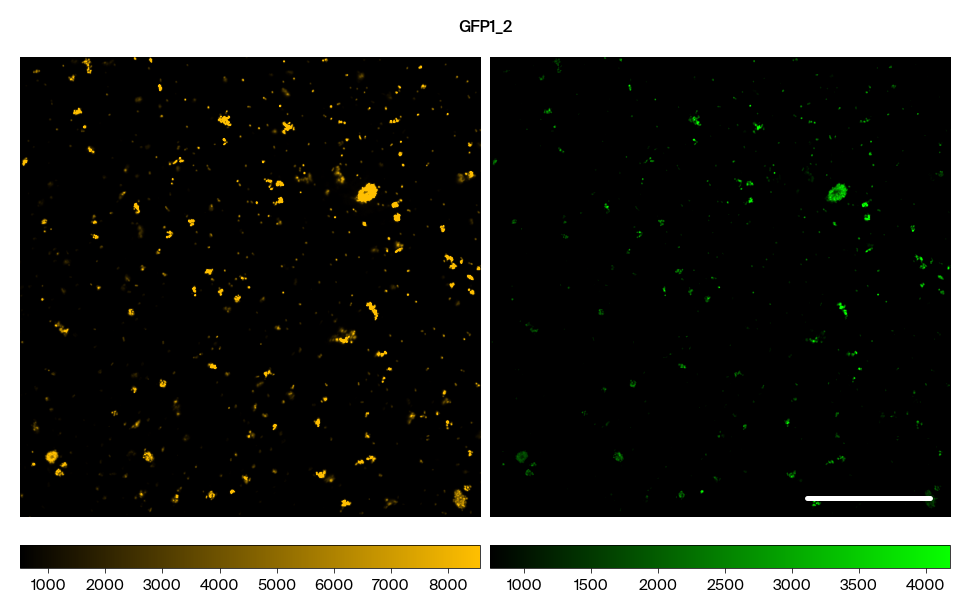

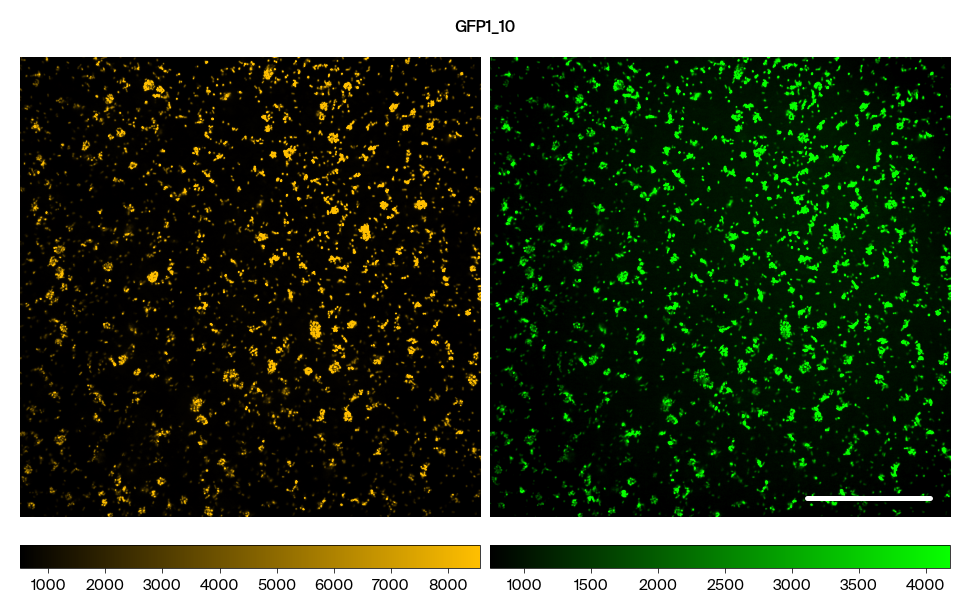

In [5]:
# Loop through ND2 files
for variant_name, nd2_path in nd2_path_map.items():
    # Create plot
    fig = plot_microscopy_image(
        nd2_path,
        vmins=vmins,
        vmaxs=vmaxs,
        scalebar_um=100,
    )

    # Add title
    title = f"{variant_name}"
    fig.suptitle(title)

    # Save figure
    filename = f"{variant_name}.pdf"
    fig.savefig(filename)